In [1]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import IPython.display as ipd
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import random
from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_curve, auc, roc_auc_score

import ast

from collections import defaultdict
from scipy.stats.stats import pearsonr

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)
#plt.rcParams['figure.figsize'] = [20, 10]
#plt.rcParams['figure.dpi'] = 50

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [3]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [4]:
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

In [5]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop'
]

In [6]:
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli)

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ALBUM_type_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
df['target']=[1 if genre == 'Rock' else 0 for genre in df['TRACK_genre_top']]

In [9]:
df2 = df[df.TRACK_genre_top.isna() == False]

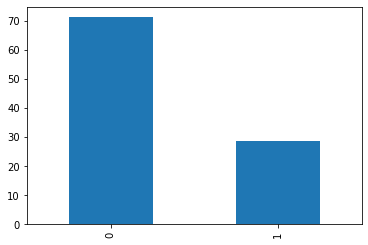

In [10]:
original = df2.target.value_counts(dropna=False).apply(lambda x: x/len(df2.index)*100)
ax = original.plot(kind='bar')

In [11]:
df2.target.value_counts(dropna=False)

0    35120
1    14155
Name: target, dtype: int64

In [12]:
lista = df2[df2.target == 1].index
lista

Int64Index([   135,    136,    151,    152,    153,    154,    155,    169,
               170,    171,
            ...
            155196, 155197, 155198, 155199, 155314, 155315, 155316, 155317,
            155318, 155319],
           dtype='int64', name='track_id', length=14155)

In [13]:
to_remove = random.sample(list(lista), 10000)

In [14]:
df_sbilanciato = df2.copy()

In [15]:
df_sbilanciato = df_sbilanciato.drop(to_remove, axis=0)

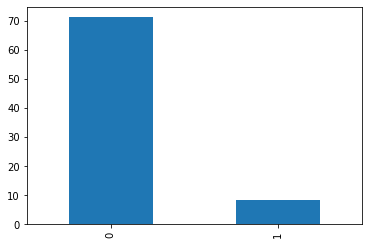

In [16]:
sbil = df_sbilanciato.target.value_counts(dropna=False).apply(lambda x: x/len(df2.index)*100)
sbil.plot(kind='bar')

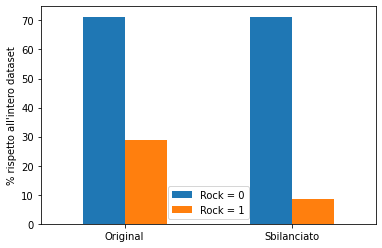

In [17]:
import matplotlib.patches as patches

frame = { 
    "Rock = 0":
    {"Original": original[0], "Sbilanciato":sbil[0]},
    "Rock = 1":
    {"Original": original[1], "Sbilanciato":sbil[1]}
}
  
result = pd.DataFrame(frame)
result.plot(kind='bar')
plt.ylabel("% rispetto all'intero dataset")
plt.xticks(rotation=0)
plt.savefig("distribuzione_target.pdf", bbox_inches="tight")
plt.show()

In [18]:
original, sbil

(0    71.273465
 1    28.726535
 Name: target, dtype: float64,
 0    71.273465
 1     8.432268
 Name: target, dtype: float64)

In [19]:
compl = Diff(tutti, bitmap + nonNumerici + nulli)

class_name = 'target'
attributes = Diff(compl, list(['TRACK_genre_top']))


X = df_sbilanciato[attributes].values
y = df_sbilanciato[class_name]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [38]:
clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=11, min_samples_split=124, criterion='gini', random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.918696427055928
F1-score [0.95568918 0.50770812]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     10536
           1       0.71      0.40      0.51      1247

    accuracy                           0.92     11783
   macro avg       0.82      0.69      0.73     11783
weighted avg       0.91      0.92      0.91     11783



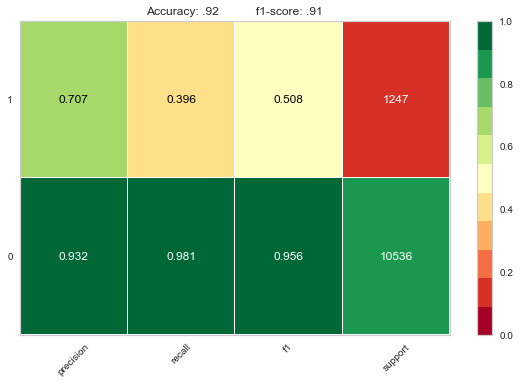

In [39]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(clf, support=True, title="Accuracy: .92           f1-score: .91", cmap="RdYlGn")
 
visualizer.score(X_test, y_test)    
visualizer.show(outpath="performance_dt_sbil.pdf")  

In [40]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

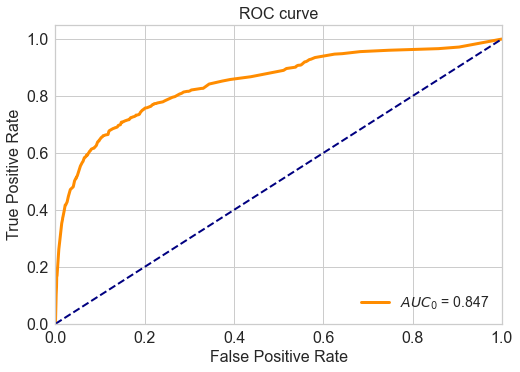

In [41]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Undersampling

### RandomUnderSampler

In [23]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

In [24]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 2908, 1: 2908})


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

param_grid = {'max_depth': [None, 10],
              'min_samples_split': range(20, 100 +1, 1),
              'min_samples_leaf': [42]
         }

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, cv=5, scoring='accuracy')
grid_search.fit(X_res, y_res)


#Model with rank: 1
#Mean validation score: 0.760 (std: 0.008)
#Parameters: {'max_depth': 10, 'min_samples_leaf': 42, 'min_samples_split': 90}

In [25]:
clf = DecisionTreeClassifier(min_samples_leaf=42, max_depth=10, min_samples_split=90, random_state=42)
clf.fit(X_res, y_res)
y_pred0 = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.8068403632351693
F1-score [0.8828133 0.4507722]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     10536
           1       0.32      0.75      0.45      1247

    accuracy                           0.81     11783
   macro avg       0.64      0.78      0.67     11783
weighted avg       0.90      0.81      0.84     11783



C:\Users\falle\anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


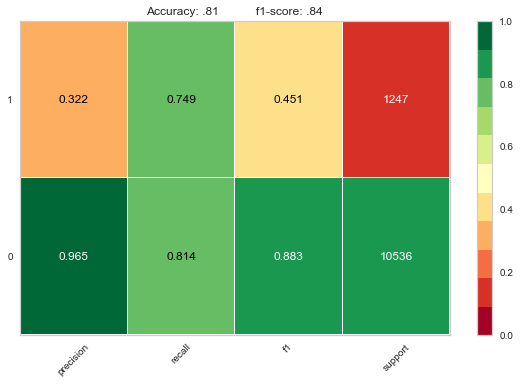

In [26]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(clf, support=True, title="Accuracy: .81           f1-score: .84", cmap="RdYlGn")
 
visualizer.score(X_test, y_test)    
visualizer.show(outpath="performance_dt_under.pdf")  

In [27]:
y_score = clf.predict_proba(X_test)
fpr1, tpr1, _ = roc_curve(y_test, y_score[:, 1])
roc_auc1 = auc(fpr1, tpr1)

### CondensedNearestNeighbour

In [28]:
import warnings
warnings.simplefilter("ignore")

In [29]:
X_train.shape, y_train.shape

((27492, 88), (27492,))

In [30]:
indices = np.random.choice(X_train.shape[0], 5000, replace=False)
X_train_sampled = X_train[indices]
y_train_sampled = y_train.iloc[indices]
X_train_sampled.shape, y_train_sampled.shape

((5000, 88), (5000,))

In [65]:
cnn = CondensedNearestNeighbour(random_state=42)
X_res, y_res = cnn.fit_resample(X_train_sampled, y_train_sampled)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1085, 1: 532})


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

param_grid = {'max_depth': [None] + [10, 20],
              'min_samples_split': [1, 2, 5, 10, 30, 50, 100],
              'min_samples_leaf': [1, 2, 5, 10, 30, 50, 100, 250]
         }

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, cv=5, scoring='accuracy')
grid_search.fit(X_res, y_res)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 5, 10, 30, 50, 100, 250],
                         'min_samples_split': [1, 2, 5, 10, 30, 50, 100]},
             scoring='accuracy', verbose=10)

In [34]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.753 (std: 0.027)
Parameters: {'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 100}

Model with rank: 1
Mean validation score: 0.753 (std: 0.027)
Parameters: {'max_depth': 20, 'min_samples_leaf': 30, 'min_samples_split': 100}

Model with rank: 3
Mean validation score: 0.751 (std: 0.023)
Parameters: {'max_depth': None, 'min_samples_leaf': 30, 'min_samples_split': 100}

Model with rank: 4
Mean validation score: 0.745 (std: 0.029)
Parameters: {'max_depth': None, 'min_samples_leaf': 50, 'min_samples_split': 5}

Model with rank: 4
Mean validation score: 0.745 (std: 0.029)
Parameters: {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 100}

Model with rank: 4
Mean validation score: 0.745 (std: 0.029)
Parameters: {'max_depth': 20, 'min_samples_leaf': 50, 'min_samples_split': 30}

Model with rank: 4
Mean validation score: 0.745 (std: 0.029)
Parameters: {'max_depth': 20, 'min_samples_leaf': 50, 'min_samples_split': 100}

Model

In [66]:
clf = DecisionTreeClassifier(min_samples_leaf=30, max_depth=None, min_samples_split=50, random_state=42)
clf.fit(X_res, y_res)
y_pred0 = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.8696427055928032
F1-score [0.92547307 0.48037889]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     10536
           1       0.42      0.57      0.48      1247

    accuracy                           0.87     11783
   macro avg       0.68      0.74      0.70     11783
weighted avg       0.89      0.87      0.88     11783



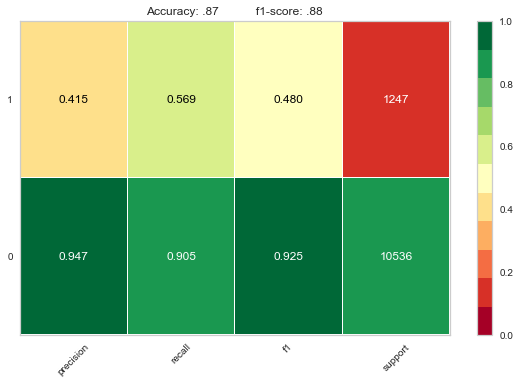

In [37]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(clf, support=True, title="Accuracy: .87           f1-score: .88", cmap="RdYlGn")
 
visualizer.score(X_test, y_test)    
visualizer.show(outpath="performance_dt_condensed.pdf")  

In [67]:
y_score = clf.predict_proba(X_test)
fpr4, tpr4, _ = roc_curve(y_test, y_score[:, 1])
roc_auc4 = auc(fpr4, tpr4)

# Oversampling

### RandomOverSampler

In [42]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [43]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 24584, 1: 24584})


In [44]:
clf = DecisionTreeClassifier(min_samples_leaf=25, max_depth=None, min_samples_split=39, random_state=42)
clf.fit(X_res, y_res)
y_pred0 = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.8566578969702113
F1-score [0.91662141 0.48957389]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     10536
           1       0.39      0.65      0.49      1247

    accuracy                           0.86     11783
   macro avg       0.67      0.77      0.70     11783
weighted avg       0.90      0.86      0.87     11783



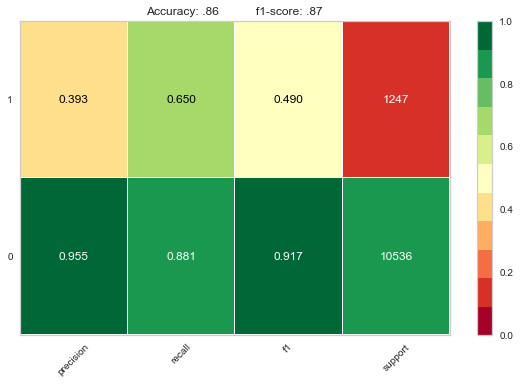

In [45]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(clf, support=True, title="Accuracy: .86           f1-score: .87", cmap="RdYlGn")
 
visualizer.score(X_test, y_test)    
visualizer.show(outpath="performance_dt_over.pdf")

In [46]:
y_score = clf.predict_proba(X_test)
fpr2, tpr2, _ = roc_curve(y_test, y_score[:, 1])
roc_auc2 = auc(fpr2, tpr2)

### SMOTE

In [47]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 24584, 1: 24584})


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

param_grid = {'max_depth': [None],
              'min_samples_split': range(16, 120, 2),
              'min_samples_leaf': range(20, 45 +1, 1)
         }

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, cv=5, scoring='accuracy')
grid_search.fit(X_res, y_res)

#Model with rank: 1
#Mean validation score: 0.876 (std: 0.026)
#Parameters: {'max_depth': None, 'min_samples_leaf': 23, 'min_samples_split': 42}

Fitting 5 folds for each of 1352 candidates, totalling 6760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None], 'min_samples_leaf': range(20, 46),
                         'min_samples_split': range(16, 120, 2)},
             scoring='accuracy', verbose=10)

In [43]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.876 (std: 0.026)
Parameters: {'max_depth': None, 'min_samples_leaf': 23, 'min_samples_split': 42}

Model with rank: 2
Mean validation score: 0.876 (std: 0.026)
Parameters: {'max_depth': None, 'min_samples_leaf': 23, 'min_samples_split': 24}

Model with rank: 3
Mean validation score: 0.876 (std: 0.026)
Parameters: {'max_depth': None, 'min_samples_leaf': 22, 'min_samples_split': 30}

Model with rank: 4
Mean validation score: 0.876 (std: 0.026)
Parameters: {'max_depth': None, 'min_samples_leaf': 23, 'min_samples_split': 32}

Model with rank: 5
Mean validation score: 0.876 (std: 0.026)
Parameters: {'max_depth': None, 'min_samples_leaf': 22, 'min_samples_split': 28}

Model with rank: 6
Mean validation score: 0.876 (std: 0.026)
Parameters: {'max_depth': None, 'min_samples_leaf': 23, 'min_samples_split': 16}

Model with rank: 7
Mean validation score: 0.876 (std: 0.026)
Parameters: {'max_depth': None, 'min_samples_leaf': 23, 'min_samples_split': 28}


In [55]:
clf = DecisionTreeClassifier(min_samples_leaf=23, max_depth=None, min_samples_split=42, random_state=42)
clf.fit(X_res, y_res)
y_pred0 = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.8604769583297972
F1-score [0.91918199 0.49007444]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     10536
           1       0.40      0.63      0.49      1247

    accuracy                           0.86     11783
   macro avg       0.68      0.76      0.70     11783
weighted avg       0.89      0.86      0.87     11783



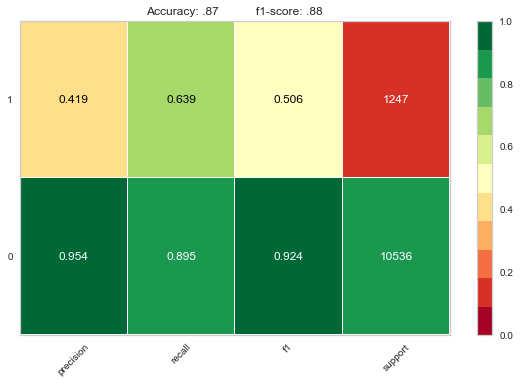

In [34]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(clf, support=True, title="Accuracy: .87           f1-score: .88", cmap="RdYlGn")
 
visualizer.score(X_test, y_test)    
visualizer.show(outpath="performance_dt_smote.pdf")

In [56]:
y_score = clf.predict_proba(X_test)
fpr3, tpr3, _ = roc_curve(y_test, y_score[:, 1])
roc_auc3 = auc(fpr3, tpr3)

# Class Weight

In [78]:
#clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=11, min_samples_split=124, criterion='gini',
#                             class_weight='balanced', random_state=42)
clf = DecisionTreeClassifier(min_samples_leaf=1, max_depth=None, min_samples_split=3, criterion='gini',
                             class_weight={0: 1, 1: 10},random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

Accuracy 0.8916235254179751
F1-score [0.93947007 0.48278655]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10536
           1       0.49      0.48      0.48      1247

    accuracy                           0.89     11783
   macro avg       0.71      0.71      0.71     11783
weighted avg       0.89      0.89      0.89     11783



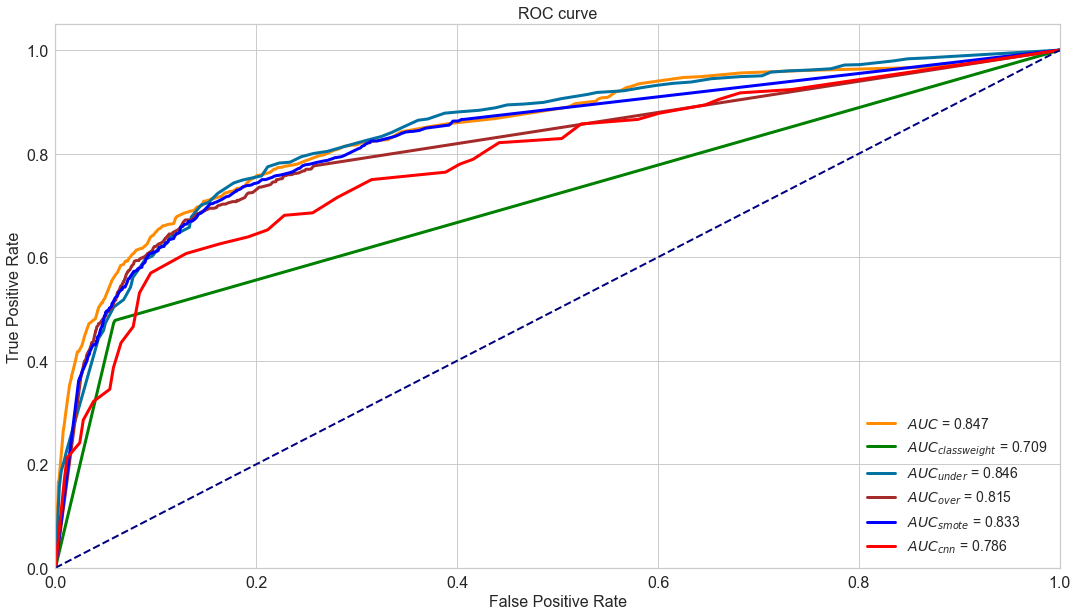

In [83]:
plt.figure(figsize=(18,10))
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_{class weight}$ = %.3f' % (roc_auc))
plt.plot(fpr1, tpr1, lw=3, label='$AUC_{under}$ = %.3f' % (roc_auc1))
plt.plot(fpr2, tpr2, color='brown', lw=3, label='$AUC_{over}$ = %.3f' % (roc_auc2))
plt.plot(fpr3, tpr3, color='blue', lw=3, label='$AUC_{smote}$ = %.3f' % (roc_auc3))
plt.plot(fpr4, tpr4, color='red', lw=3, label='$AUC_{cnn}$ = %.3f' % (roc_auc4))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("compare_roc_imb.pdf",bbox_inches="tight")
plt.show()

In [49]:
param_grid = {'max_depth': [None],
              'min_samples_split': range(1, 40 +1, 2),
              'min_samples_leaf': range(1, 20 +1, 2),
              'class_weight': ['balanced', {0:1, 1: 10}, {0:1, 1: 20}]
         }

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

#Model with rank: 1
#Mean validation score: 0.890 (std: 0.001)
#Parameters: {'class_weight': {0: 1, 1: 10}, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3}

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 146 out of 175 | elapsed:   36.9s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done 164 out of 175 | elapsed:   37.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   41.4s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None], 'min_samples_leaf': range(17, 24),
                         'min_samples_split': range(34, 39)},
             scoring='accuracy', verbose=10)

In [52]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.877 (std: 0.029)
Parameters: {'max_depth': None, 'min_samples_leaf': 17, 'min_samples_split': 34}

Model with rank: 2
Mean validation score: 0.877 (std: 0.029)
Parameters: {'max_depth': None, 'min_samples_leaf': 17, 'min_samples_split': 35}

Model with rank: 3
Mean validation score: 0.877 (std: 0.029)
Parameters: {'max_depth': None, 'min_samples_leaf': 17, 'min_samples_split': 36}

Model with rank: 4
Mean validation score: 0.876 (std: 0.029)
Parameters: {'max_depth': None, 'min_samples_leaf': 17, 'min_samples_split': 38}

Model with rank: 5
Mean validation score: 0.876 (std: 0.029)
Parameters: {'max_depth': None, 'min_samples_leaf': 17, 'min_samples_split': 37}

Model with rank: 6
Mean validation score: 0.876 (std: 0.029)
Parameters: {'max_depth': None, 'min_samples_leaf': 19, 'min_samples_split': 35}

Model with rank: 7
Mean validation score: 0.876 (std: 0.026)
Parameters: {'max_depth': None, 'min_samples_leaf': 23, 'min_samples_split': 34}


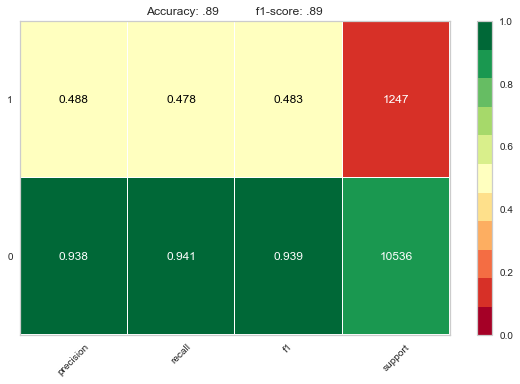

In [53]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(clf, support=True, title="Accuracy: .89           f1-score: .89", cmap="RdYlGn")
 
visualizer.score(X_test, y_test)    
visualizer.show(outpath="performance_dt_class.pdf")